In [22]:
import relay_bp
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt


import sinter
import multiprocessing

import sys
from pathlib import Path

# Make test utilities importable
tests_dir = Path.cwd().parent / "tests"
if str(tests_dir) not in sys.path:
    sys.path.insert(0, str(tests_dir))

# Make BBcode module importable (from qPLDC-circuits/tomas)
# bb_dir = (Path.cwd().parents[2] / "qPLDC-circuits" / "tomas").resolve()
# if str(bb_dir) not in sys.path:
#     sys.path.insert(0, str(bb_dir))
import BBcode

# Import Relay-BP Sinter decoder API
from relay_bp.stim.sinter.decoders import (
    SinterDecoder_RelayBP,
    sinter_decoders,
)

In [23]:
import os, sys, importlib
from pathlib import Path

qasm_dir = "./bb_code_qasm"
os.makedirs(qasm_dir, exist_ok=True)

# New: directory for saved results
results_dir = "./results"
os.makedirs(results_dir, exist_ok=True)

# Add stabilizer/src to PYTHONPATH using a path relative to this notebook
try:
    base_dir = Path(__file__).resolve().parent
except NameError:
    base_dir = Path.cwd().resolve()
src_dir = (base_dir.parents[3] / "src").resolve()  # .../stabilizer/src
if str(src_dir) not in sys.path:
    sys.path.insert(0, str(src_dir))

import noise_util as ns
importlib.reload(ns)

<module 'noise_util' from '/Users/garn195/Library/CloudStorage/OneDrive-PNNL/Project_Repositories/NWQ-Sim/stabilizer/src/noise_util.py'>

In [24]:
import subprocess
import time

# Compile the C++ code once before the loop
print("Compiling C++ simulator (MPI)...")
# Adjust the path to your C++ file as needed
cpp_file_path = './bb_code_sim.cpp'
executable_path = './bb_code_sim'

compile_command = [
    "mpicxx",  # Use MPI compiler wrapper
    "-std=c++17",
    "-O3",
    "-I../../../../../", # Include for NWQ-Sim headers
    "-DMPI_ENABLED",
    "-o",
    executable_path,
    cpp_file_path
]
try:
    subprocess.run(compile_command, check=True, capture_output=True, text=True)
    print("Compilation successful.")
except subprocess.CalledProcessError as e:
    print("Compilation failed.")
    print("--- stdout ---")
    print(e.stdout)
    print("--- stderr ---")
    print(e.stderr)

Compiling C++ simulator (MPI)...
Compilation successful.
Compilation successful.


In [ ]:

#Params
circuit = "bicycle_bivariate_144_12_12_memory_Z"
distance = 12
rounds = 12
SHOTS = 500000#00

XYZ_decoding = False

# Construct Relay-BP decoder (from decoders.py)
decoder = SinterDecoder_RelayBP(
    gamma0=0.1,
    pre_iter=80,
    num_sets=60,
    set_max_iter=60,
    gamma_dist_interval=(-0.24, 0.66),
    stop_nconv=1,
    parallel=True
    )

# circuit = get_test_circuit(circuit=circuit, distance=distance, rounds=rounds, error_rate=error_rate)
# if not XYZ_decoding:
#     circuit = filter_detectors_by_basis(circuit, "Z")

# circuit.diagram("timeline-svg")


In [ ]:
#Parameters
tasks = []
T1 = 10 ** -4
T2 = 10 ** -4
# cpp_tau = np.array([4*10**-7,8*10**-7, 10**-6, 2*10**-6, 6*10**-6])
tau = np.array([4*10**-7, 6*10**-7, 8*10**-7, 9*10**-7, 10**-6, 1.5*10**-6, 2*10**-6, 4*10**-6, 6*10**-6])
lam = 1/T2 - 1/(2*T1)
p_amp = 1 - np.exp(-tau/T1)
p_phase = 1 - np.exp(-lam*tau)
p_list = (p_amp, p_phase)
base_error = 0.000

bb_code = BBcode.BBcode(
    n=144, k=12, d=12, m=6, l=12,
    A=[[3, 0], [0, 1], [0, 2]],
    B=[[0, 3], [1, 0], [2, 0]],
    shift=[0, 0],
    f=[[0, 0], [1, 0], [2, 0], [3, 0], [6, 0], [7, 0], [8, 0], [9, 0], [1, 3], [5, 3], [7, 3], [11, 3]],
    g=[[1, 0], [2, 1], [0, 2], [1, 2], [2, 3], [0, 4]],
    h=[[0, 0], [0, 1], [1, 1], [0, 2], [0, 3], [1, 3]],
    alpha=[[0, 0], [0, 1], [2, 1], [2, 5], [3, 2], [4, 0]],
    beta=[[0, 1], [0, 5], [1, 1], [0, 0], [4, 0], [5, 2]],
)
print(p_amp)
print(p_phase)
i=0
for p_amp, p_phase in zip(p_amp, p_phase):
    noise_profile = [0,0,0,0]
    circuit = bb_code.build_full_BBcode_circuit(rounds=rounds, noise_profile=noise_profile, observable_type="Z", code_capacity=True)

    #Generate stim circuit
    model = ns.ErrorModel(circuit)
    model.setting_error('Identity', False, f'DEPOLARIZE1({base_error})')
    model.setting_error('Single_qubit', False, f'DEPOLARIZE1({base_error})')
    model.setting_error('Two_qubit', False, f'DEPOLARIZE2({base_error})')
    model.setting_error('Measurement', True, f'PAULI_CHANNEL_1({p_amp/4}, {p_amp/4}, {p_amp/4 + p_phase/2})')
    model.setting_error('Reset', True, f'PAULI_CHANNEL_1({p_amp/4}, {p_amp/4}, {p_amp/4 + p_phase/2})')
    stim_circuit = model.generate_noisy_circuit()
    tasks.append(sinter.Task(circuit=stim_circuit, json_metadata={'d': distance, "trial":i}))

    #Generate stabsim circuit
    model.setting_error('Measurement', True, f'AMPLITUDE_DAMP({p_phase}, {p_amp})')
    model.setting_error('Reset', True, f'AMPLITUDE_DAMP({p_phase}, {p_amp})')
    stab_circuit = model.generate_noisy_circuit()
    qasm_output = ns.stim_to_qasm_with_depolarize_noise(stab_circuit)
    # Inject AMPLITUDE_DAMP around M/RESET in QASM using the model settings
    qasm_output = ns.inject_amplitude_damp(qasm_output, model)
    
    try:
        qasm_path = os.path.join(qasm_dir, f"bb_code_d{distance}_p{i}.qasm")
        with open(qasm_path, "w") as f:
            f.write(qasm_output)
    except Exception as e:
        print(f"Failed to export QASM for p={p_amp}: {e}")
    i+=1


[0.03921056 0.07688365 0.09516258 0.18126925 0.45118836]
[0.01980133 0.03921056 0.04877058 0.09516258 0.25918178]


In [ ]:
int(3*os.cpu_count()/4)

336

In [ ]:
num_workers = int(3*os.cpu_count()/4)

def run_stim_experiment(tasks, shots):
    stim_lers = []
    for task in tasks:
        start_time = time.perf_counter()
        iter = task.json_metadata.get('trial', 0)
        print(f"\n--- Running Stim for task = {iter} ---")
        collected_stats = sinter.collect(
            num_workers=num_workers,
            tasks=[task],
            decoders=['relay-bp'],  # use a list of names
            max_shots=shots,
            # max_errors=100,
            print_progress=False,
            custom_decoders={
                'relay-bp': SinterDecoder_RelayBP(
                gamma0=0.1,
                pre_iter=80,
                num_sets=60,
                set_max_iter=60,
                gamma_dist_interval=(-0.24, 0.66),
                stop_nconv=1,
                parallel=True
                )  # reuse the configured instance
            },
        )
        stim_time = time.perf_counter() - start_time
        stat = collected_stats[0]
        stim_ler = stat.errors / stat.shots if stat.shots > 0 else 0.0
        stim_lers.append(stim_ler)
        print(f"Stim LER: {stim_ler}, Sim+Decoding Time: {stim_time}s")
    return stim_lers

# --- Run Stim-only experiment ---

stim_logical_error_rates = run_stim_experiment(tasks, SHOTS)
print("\nStim complete.")
print("Probabilities:", p_list)
print("Stim LERs:", stim_logical_error_rates)

# Save Stim results
try:
    # Recompute probability arrays (loop earlier shadows names)
    p_amp_arr = 1 - np.exp(-tau / T1)
    lam = 1 / T2 - 1 / (2 * T1)
    p_phase_arr = 1 - np.exp(-lam * tau)

    stim_results_path = os.path.join(results_dir, f"stim_results_d{distance}_shots{SHOTS}.txt")
    with open(stim_results_path, "w") as f:
        f.write("# tau\tp_amp\tp_phase\tstim_ler\n")
        for ta, pa, pp, ler in zip(tau, p_amp_arr, p_phase_arr, stim_logical_error_rates):
            f.write(f"{ta}\t{pa}\t{pp}\t{ler}\n")
    print(f"Saved Stim results to {stim_results_path}")
except Exception as e:
    print("Failed to save Stim results:", e)


--- Running Stim for task = 0 ---
Stim LER: 2.66e-06, Sim+Decoding Time: 75.53361463733017s

--- Running Stim for task = 1 ---
Stim LER: 6.32e-06, Sim+Decoding Time: 80.81843154877424s

--- Running Stim for task = 2 ---
Stim LER: 7.7e-06, Sim+Decoding Time: 86.30147890560329s

--- Running Stim for task = 3 ---
Stim LER: 8.96e-06, Sim+Decoding Time: 89.16863499954343s

--- Running Stim for task = 4 ---
Stim LER: 9.44e-06, Sim+Decoding Time: 90.80523727834225s

--- Running Stim for task = 5 ---
Stim LER: 1.086e-05, Sim+Decoding Time: 100.70041992515326s

--- Running Stim for task = 6 ---
Stim LER: 1.344e-05, Sim+Decoding Time: 110.77121039479971s

--- Running Stim for task = 7 ---
Stim LER: 0.00030324, Sim+Decoding Time: 180.823021966964s

--- Running Stim for task = 8 ---
Stim LER: 0.00371254, Sim+Decoding Time: 555.5926687959582s

Stim complete.
Probabilities: (array([0.00399201, 0.00598204, 0.00796809, 0.00895962, 0.00995017,
       0.01488806, 0.01980133, 0.03921056, 0.05823547]), a

In [ ]:
from concurrent.futures import ProcessPoolExecutor
from relay_bp.stim.sinter.decoders import SinterCompiledDecoder_BP

env = os.environ.copy()
env.update({
    "OMP_NUM_THREADS": "1",
    "OPENBLAS_NUM_THREADS": "1",
    "MKL_NUM_THREADS": "1",
    "VECLIB_MAXIMUM_THREADS": "1",
    "NUMEXPR_NUM_THREADS": "1",
})

def run_cpp_experiment(tasks, shots):
    cpp_lers = []
    if not tasks:
        return cpp_lers

    # Compile converters/decoder ONCE (structure is identical across p)


    for task in tasks:
        trial = task.json_metadata.get("trial")
        d = distance

        ref_circ = task.circuit
        m2d_converter = ref_circ.compile_m2d_converter()
        dem = ref_circ.detector_error_model(
            decompose_errors=True,
            ignore_decomposition_failures=True,
        )
        compiled = decoder.compile_decoder_for_dem(dem=dem)
        
        print(f"\n--- Running C++ (MPI) for trial {trial} ---")

        # Paths (absolute to avoid cwd confusion)
        qasm_file_path = os.path.abspath(os.path.join(qasm_dir, f"bb_code_d{d}_p{trial}.qasm"))
        cpp_output_path = os.path.abspath(os.path.join(qasm_dir, f"measurements_d{d}_p{trial}.bin"))

        # Remove any stale output (e.g., old ASCII file)
        try:
            if os.path.exists(cpp_output_path):
                os.remove(cpp_output_path)
        except Exception:
            pass

        # MPI execution
        num_qubits = task.circuit.num_qubits
        mpi_ranks = max(1, min(int(3*os.cpu_count()/4), shots))  # don't spawn more ranks than shots


        run_command = [
            "mpirun", "-np", str(mpi_ranks),
            "./bb_code_sim", str(num_qubits), str(shots), qasm_file_path, cpp_output_path
        ]

        cpp_time = 0.0
        try:
            result = subprocess.run(run_command, check=True, capture_output=True,text=True, env=env)
            for line in result.stdout.strip().split('\n'):
                if "Total C++ simulation time" in line:
                    try:
                        cpp_time = float(line.split(':')[1].strip().replace('s', ''))
                    except (ValueError, IndexError):
                        pass
                if line.startswith("NWQB header v"):
                    print(line)
        except subprocess.CalledProcessError as e:
            print("C++ simulation failed to execute.")
            print("Return code:", e.returncode)
            print("--- stdout ---")
            print(e.stdout)
            print("--- stderr ---")
            print(e.stderr)
            cpp_lers.append(0.0)
            continue

        # Decode with the same Relay-BP decoder used for Stim via a compiled decoder
        try:
            # 1) Load packed binary measurements written by MPI code
            #    Header: [u32 magic='NWQB'][u32 version=1][u64 mlen][u64 shots], followed by shots rows of ceil(mlen/8) bytes.
            with open(cpp_output_path, "rb") as f:
                header_u32 = np.fromfile(f, dtype=np.uint32, count=2)
                header_u64 = np.fromfile(f, dtype=np.uint64, count=2)
                if header_u32.size != 2 or header_u64.size != 2:
                    raise RuntimeError("Invalid C++ binary header (size)")
                magic, version = int(header_u32[0]), int(header_u32[1])
                mlen, shots_file = int(header_u64[0]), int(header_u64[1])
                if magic != 0x4E575142:
                    raise RuntimeError(f"Invalid magic in C++ binary (got {magic:#x})")
                if version != 1:
                    raise RuntimeError(f"Unsupported C++ binary version {version}")
                bytes_per_shot = (mlen + 7) // 8
                packed = np.fromfile(f, dtype=np.uint8)

            if shots_file == 0 or packed.size == 0:
                cpp_lers.append(0.0)
                print("No C++ measurements found; LER set to 0.0")
                continue
            expected = shots_file * bytes_per_shot
            if packed.size != expected:
                raise RuntimeError(f"Packed data size mismatch: got {packed.size}, expected {expected}")

            bit_packed_meas = np.ascontiguousarray(packed.reshape(shots_file, bytes_per_shot))

            # 2) Convert measurements -> detection events + observables
            try:
                det_samples, obs_flips = m2d_converter.convert_measurements_bit_packed(
                    bit_packed_meas,
                    separate_observables=True,
                    bit_packed_order='little',
                )
            except AttributeError:
                # Fallback if converter lacks packed API
                meas_bool = np.unpackbits(bit_packed_meas, bitorder="little", axis=1)[:, :mlen].astype(bool, copy=False)
                det_samples, obs_flips = m2d_converter.convert(
                    measurements=meas_bool,
                    separate_observables=True,
                )

            # 3) Bit-pack detection events for compiled decoder API
            det_u8 = det_samples.astype(np.uint8, copy=False)
            bit_packed = np.packbits(det_u8, axis=1, bitorder="little")
            bit_packed = np.ascontiguousarray(bit_packed)

            # 4) Batch decode
            start_time = time.perf_counter()
            pred_obs_b8 = compiled.decode_shots_bit_packed(
                bit_packed_detection_event_data=bit_packed
            )
            pred_obs = np.unpackbits(pred_obs_b8, bitorder="little", axis=1)[:, : dem.num_observables]
            stab_decode_time = time.perf_counter() - start_time

            total_errors = int(np.any(pred_obs != obs_flips.astype(np.uint8), axis=1).sum())
            cpp_ler = float(total_errors) / float(len(pred_obs)) if len(pred_obs) else 0.0
            print(f"C++ LER: {cpp_ler:.4f}, Sim Time: {cpp_time:.4f}s, Decoding Time {stab_decode_time:.4f}s")
        except Exception as e:
            print("C++ decoding failed:", e)
            cpp_ler = 1.0

        cpp_lers.append(cpp_ler)

    return cpp_lers

# --- Run C++-only experiment ---
cpp_logical_error_rates = run_cpp_experiment(tasks, SHOTS)
print("\nC++ complete.")
print("Probabilities:", p_list)
print("C++ LERs:", cpp_logical_error_rates)

# Save C++ results
try:
    p_amp_arr = 1 - np.exp(-tau / T1)
    lam = 1 / T2 - 1 / (2 * T1)
    p_phase_arr = 1 - np.exp(-lam * tau)
    cpp_results_path = os.path.join(results_dir, f"cpp_results_d{distance}_shots{SHOTS}.txt")
    with open(cpp_results_path, "w") as f:
        f.write("# tau\tp_amp\tp_phase\tcpp_ler\n")
        for ta, pa, pp, ler in zip(tau, p_amp_arr, p_phase_arr, cpp_logical_error_rates):
            f.write(f"{ta}\t{pa}\t{pp}\t{ler}\n")
    print(f"Saved C++ results to {cpp_results_path}")
except Exception as e:
    print("Failed to save C++ results:", e)


--- Running C++ (MPI) for trial 0 ---
NWQB header v1: mlen=1872, shots=5000000, bytes_per_shot=234
C++ LER: 0.0000, Sim Time: 1793580.0000s, Decoding Time 16.9549s

--- Running C++ (MPI) for trial 1 ---
NWQB header v1: mlen=1872, shots=5000000, bytes_per_shot=234
C++ LER: 0.0000, Sim Time: 1775240.0000s, Decoding Time 30.6480s

--- Running C++ (MPI) for trial 2 ---
NWQB header v1: mlen=1872, shots=5000000, bytes_per_shot=234
C++ LER: 0.0000, Sim Time: 1753550.0000s, Decoding Time 19.0083s

--- Running C++ (MPI) for trial 3 ---
NWQB header v1: mlen=1872, shots=5000000, bytes_per_shot=234
C++ LER: 0.0001, Sim Time: 1759270.0000s, Decoding Time 29.2504s

--- Running C++ (MPI) for trial 4 ---
NWQB header v1: mlen=1872, shots=5000000, bytes_per_shot=234
C++ LER: 0.0021, Sim Time: 1785870.0000s, Decoding Time 40.9722s

C++ complete.
Probabilities: (array([0.00399201, 0.00796809, 0.00995017, 0.01980133, 0.05823547]), array([0.001998  , 0.00399201, 0.00498752, 0.00995017, 0.02955447]))
C++ LE

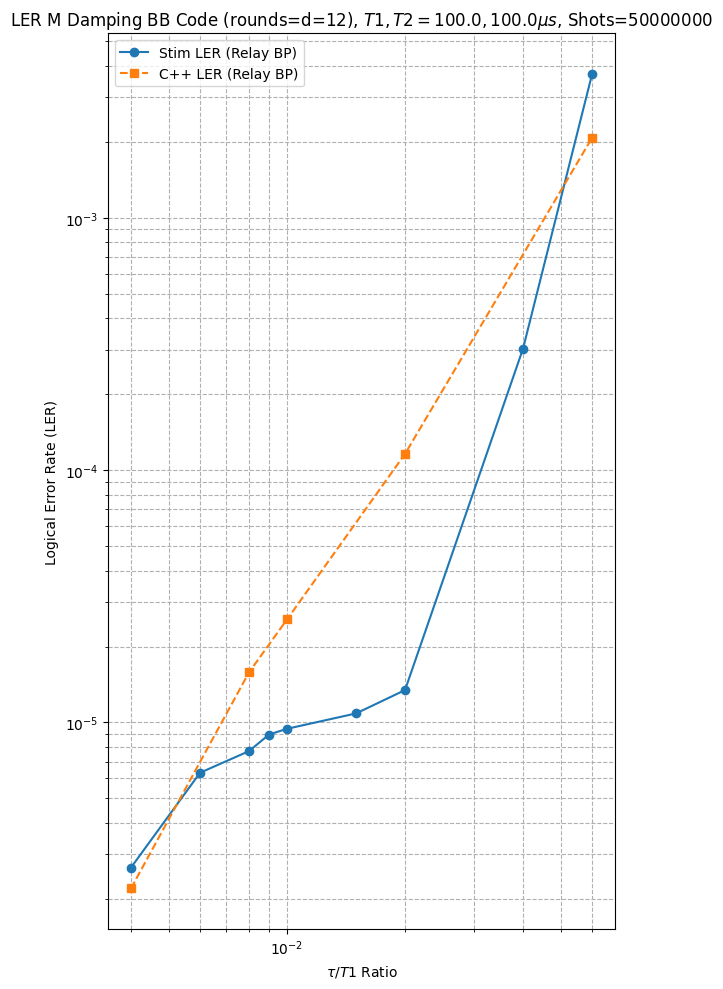

In [ ]:
# --- Plotting Results ---
plt.figure(figsize=(6, 10))

plt.plot(tau/T1, stim_logical_error_rates, 'o-', label='Stim LER (Relay BP)')
plt.plot(cpp_tau/T1, cpp_logical_error_rates, 's--', label='C++ LER (Relay BP)')
plt.xlabel(r"$\tau / T1$ Ratio")
plt.ylabel("Logical Error Rate (LER)")
plt.title(rf"LER M Damping BB Code (rounds=d={distance}), $T1,T2 = {T1*10**6},{T2*10**6} \mu s$, Shots={SHOTS}")
plt.xscale('log')
plt.yscale('log')
plt.xlim()
# plt.xticks(p_list_extend, [f"{p:.0e}" for p in p_list_extend])
plt.grid(True, which="both", ls="--")
plt.legend()
plt.tight_layout()
plt.savefig(f'../../../figures/BB_code_LER{SHOTS}.pdf', dpi=500, bbox_inches='tight')
plt.show()

# New cell: Load from files and re-plot without recomputing


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Reload and plot previously saved results
try:
    # Fallback if results_dir isn't defined in this session
    results_dir = globals().get('results_dir', './results')
    stim_results_path = Path(results_dir) / f"stim_results_d{distance}_shots{SHOTS}.txt"
    cpp_results_path = Path(results_dir) / f"cpp_results_d{distance}_shots{SHOTS}.txt"

    if not stim_results_path.exists() or not cpp_results_path.exists():
        missing = []
        if not stim_results_path.exists():
            missing.append(str(stim_results_path))
        if not cpp_results_path.exists():
            missing.append(str(cpp_results_path))
        raise FileNotFoundError("Missing results files: " + ", ".join(missing))

    def load_results(path):
        data = []
        with open(path, 'r') as f:
            for line in f:
                if line.startswith('#') or not line.strip():
                    continue
                parts = line.strip().split('\t')
                if len(parts) >= 4:
                    ta, pa, pp, ler = map(float, parts[:4])
                    data.append((ta, pa, pp, ler))
        data = np.array(data)
        return data[:, 0], data[:, 1], data[:, 2], data[:, 3]

    tau_s, p_amp_s, p_phase_s, stim_ler_s = load_results(stim_results_path)
    tau_c, p_amp_c, p_phase_c, cpp_ler_c = load_results(cpp_results_path)

    # Basic consistency check
    if not np.allclose(tau_s, tau_c):
        print("Warning: tau arrays differ between Stim and C++ results; proceeding with Stim taus for x-axis.")

    plt.figure(figsize=(6, 10))
    plt.plot(tau_s / T1, stim_ler_s, 'o-', label='Stim LER (Relay BP) [loaded]')
    plt.plot(tau_c / T1, cpp_ler_c, 's--', label='C++ LER (Relay BP) [loaded]')
    plt.xlabel(r"$\\tau / T1$ Ratio")
    plt.ylabel("Logical Error Rate (LER)")
    plt.title(rf"Loaded LER M Damping BB Code (rounds=d={distance}), $T1,T2 = {T1*10**6},{T2*10**6}\\mu s$, Shots={SHOTS}")
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True, which="both", ls="--")
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Failed to load and plot saved results:", e)

Failed to load and plot saved results: 
$\\tau / T1$ Ratio
^
ParseException: Expected end of text, found '$'  (at char 0), (line:1, col:1)
Error in callback <function _draw_all_if_interactive at 0x7fcc6e560c10> (for post_execute), with arguments args (),kwargs {}:


ValueError: 
Loaded LER M Damping BB Code (rounds=d=12), $T1,T2 = 100.0,100.0\\mu s$, Shots=5000000
                                            ^
ParseException: Expected end of text, found '$'  (at char 44), (line:1, col:45)

ValueError: 
Loaded LER M Damping BB Code (rounds=d=12), $T1,T2 = 100.0,100.0\\mu s$, Shots=5000000
                                            ^
ParseException: Expected end of text, found '$'  (at char 44), (line:1, col:45)

<Figure size 600x1000 with 1 Axes>